## GROUP N°

## NAMES 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import other libraries when needed 

## 1. DATA PROCESSING

In [20]:
# Load raw data
df = pd.read_parquet("dataDumper.parquet")

In [21]:
df.head()

,Time_utc,VehicleName,VehicleType,Pressure_Pa_1,Pressure_Pa_2,Pressure_Pa_3,Pressure_Pa_4,Pressure_Pa_5,Pressure_Pa_6,Temperature_K_1,...,Altitude_m,Speed_mps,epsilonX,epsilonY,epsilonZ,epsilonSpeed,AtmosphericPressure_Pa,dt_s,dd_m,RatioPayload
0,2023-01-01 00:00:00.328,C-132,Dumper,993010.933333,1.003995e+06,856000.0,798005.466667,819994.533333,864994.533333,346.15,...,4581.000000,9.003,6.207,6.312,23.000000,0.0,59002.557667,4.912,41.480140,0.0
1,2023-01-01 00:00:05.338,C-132,Dumper,993177.933329,1.003911e+06,856000.0,798088.966665,819911.033335,864911.033335,346.15,...,4577.600098,9.003,6.393,6.797,27.600000,0.0,59028.296172,5.010,45.952211,0.0
2,2023-01-01 00:00:10.331,C-132,Dumper,993344.366669,1.003828e+06,856000.0,798172.183334,819827.816666,864827.816666,346.15,...,4573.000000,9.723,6.721,7.631,32.200001,0.0,59064.789917,4.993,47.007842,0.0
3,2023-01-01 00:00:15.325,C-132,Dumper,993510.833331,1.003745e+06,856000.0,798255.416666,819744.583334,864744.583334,346.15,...,4568.600098,9.620,6.361,6.504,23.000000,0.0,59101.596928,4.994,48.700870,0.0
4,2023-01-01 00:00:20.448,C-132,Dumper,993681.600000,1.003659e+06,856000.0,798340.800000,819659.200000,864659.200000,346.15,...,4564.500000,11.318,6.361,7.144,23.000000,0.0,59139.354701,5.123,52.675397,0.0


In [22]:
df.columns

Index(['Time_utc', 'VehicleName', 'VehicleType', 'Pressure_Pa_1',
       'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5',
       'Pressure_Pa_6', 'Temperature_K_1', 'Temperature_K_2',
       'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5',
       'Temperature_K_6', 'ColdPressure_Pa_1', 'ColdPressure_Pa_2',
       'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5',
       'ColdPressure_Pa_6', 'Latitude_dd', 'Longitude_dd', 'Altitude_m',
       'Speed_mps', 'epsilonX', 'epsilonY', 'epsilonZ', 'epsilonSpeed',
       'AtmosphericPressure_Pa', 'dt_s', 'dd_m', 'RatioPayload'],
      dtype='object')

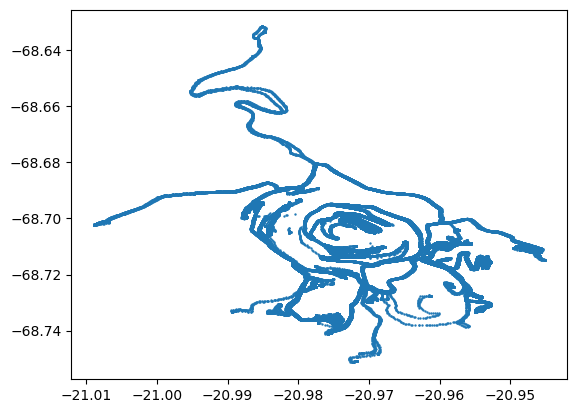

In [23]:
plt.scatter(x = df['Latitude_dd'], y = df['Longitude_dd'], s=0.5)

In [24]:
plot = df[['Longitude_dd','Latitude_dd']]

In [44]:
test = df[['Longitude_dd','Latitude_dd']][0:500]

In [47]:
test.to_csv("test.csv")

## Trajectory Construction

In [25]:
# Create Segments based on  RatioPayLoad
df[['phaseNb']] = df[['RatioPayload']].diff().abs().cumsum()

In [26]:
#Split the data into loaded trajectories and empty trajectories
segment_list = [data_phase for _, data_phase in df.groupby('phaseNb')]
empty_segment_list = []
load_segment_list = []

for segment in segment_list:
    if segment.RatioPayload.mean() == 0.0:
        empty_segment_list.append(segment)
    elif segment.RatioPayload.mean() == 1.0:
        load_segment_list.append(segment)

In [27]:
print(f'N° of Loaded segments :{len(load_segment_list)}')
print(f'N° of Empty segments :{len(empty_segment_list)}')

N° of Loaded segments :263
N° of Empty segments :263


<Axes: xlabel='Latitude_dd', ylabel='Longitude_dd'>

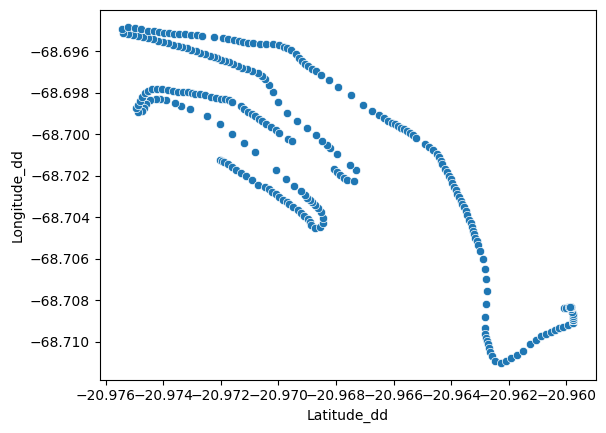

In [28]:
sns.scatterplot(x = load_segment_list[5]['Latitude_dd'],
                y = load_segment_list[5]['Longitude_dd'])

Voir le temps entre 2 pts

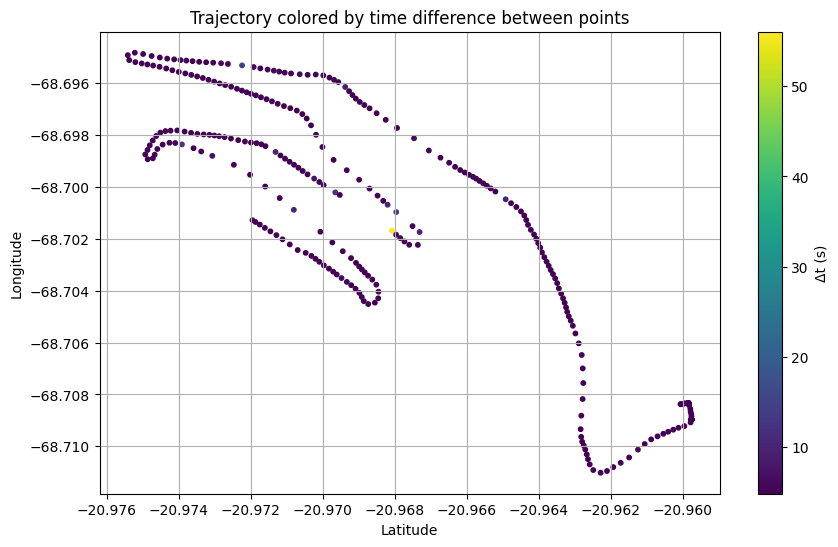

In [29]:
# Copie du segment à tracer
segment = load_segment_list[5].copy()

# Conversion en datetime si ce n’est pas déjà fait
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'])

# Calcul du delta temps entre points successifs (en secondes)
segment['time_diff_s'] = segment['Time_utc'].diff().dt.total_seconds()

# Plot avec couleurs selon l’intervalle de temps
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=segment['Latitude_dd'],
    y=segment['Longitude_dd'],
    c=segment['time_diff_s'],
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label='Δt (s)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Trajectory colored by time difference between points')
plt.grid(True)
plt.show()


Option 2 : Annoter manuellement quelques points avec Δt (pour peu de points)

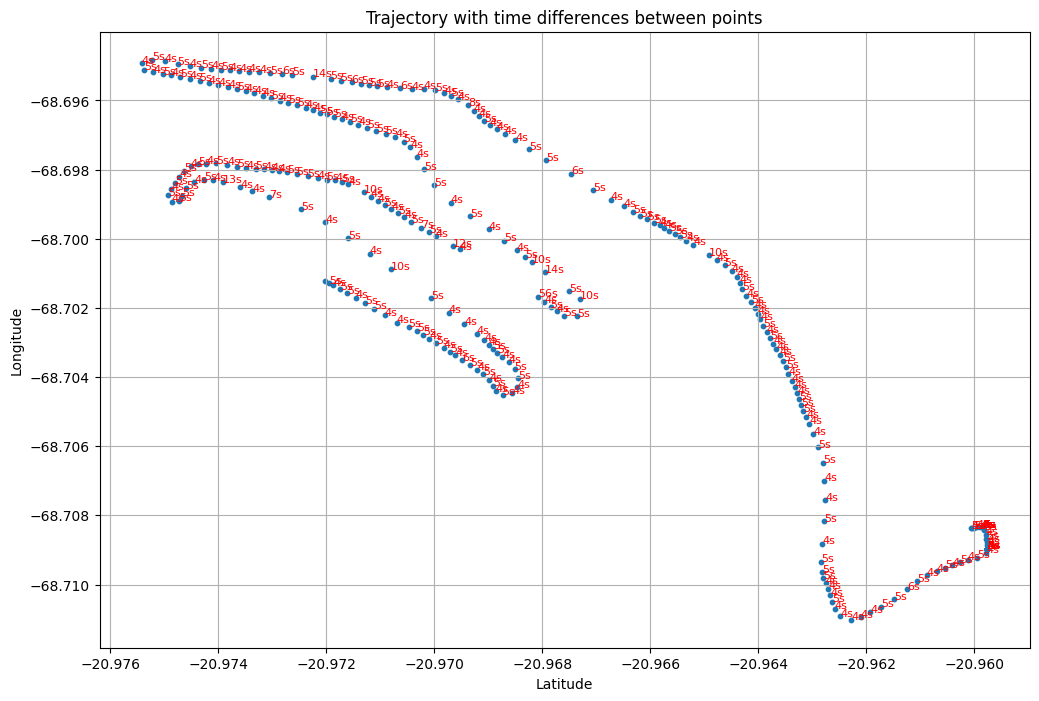

In [30]:
segment = load_segment_list[5].copy()
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'])
segment['time_diff_s'] = segment['Time_utc'].diff().dt.total_seconds()

plt.figure(figsize=(12, 8))
plt.scatter(segment['Latitude_dd'], segment['Longitude_dd'], s=10)

# Annotation de Δt sur chaque point (sauf le premier)
for i in range(1, len(segment)):
    lat = segment.iloc[i]['Latitude_dd']
    lon = segment.iloc[i]['Longitude_dd']
    delta_t = segment.iloc[i]['time_diff_s']
    plt.text(lat, lon, f"{int(delta_t)}s", fontsize=8, color='red')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Trajectory with time differences between points')
plt.grid(True)
plt.show()


Faire une trajectoire avec des points toute les 5 sec 

## 2. DATA ANALYSIS

Perform a comprehensive analysis of the dataset to uncover underlying patterns or characteristics. Visualize data distributions and relationships, such as speed vs. time, acceleration profiles, or geographical movements ... BE CURIOUS 

Vitesse & accélération vs time 

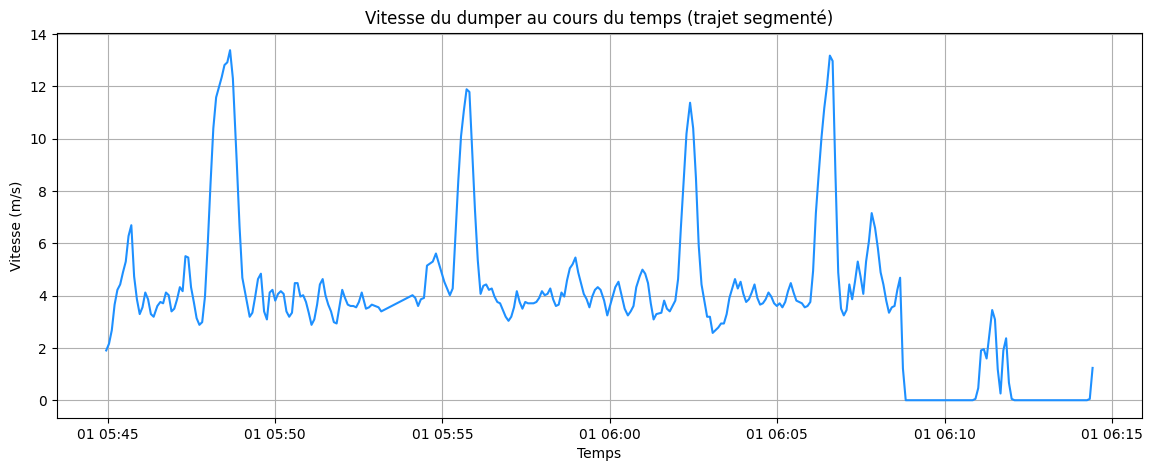

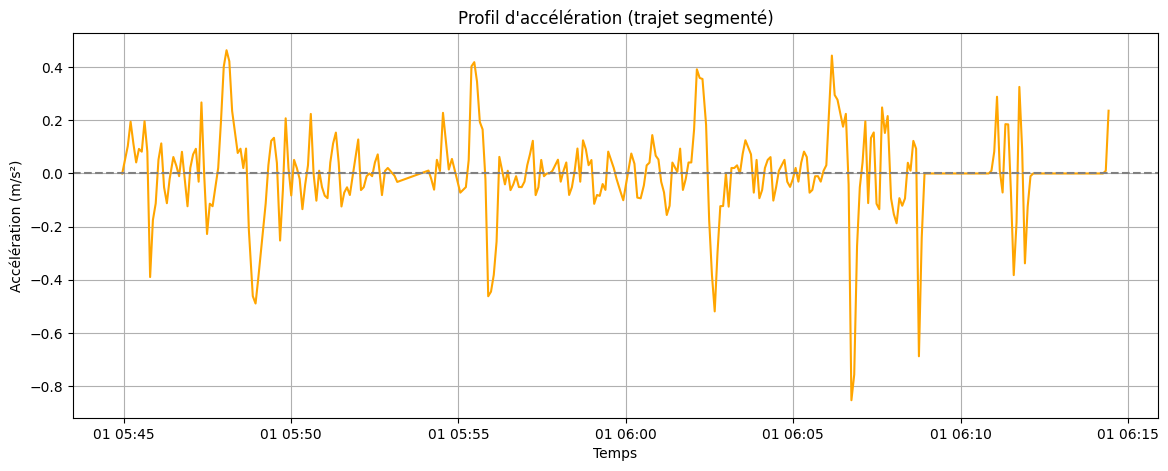

In [ ]:
# ANALYSE THE MUTLIVARIATE TIME SERIES, TRY TO FIND PATTERNS AND CORRELATIONS INT THE DATA
# CHECK HOW THE DUMPER BEHAVES, SPEED, ACCELERATION, ... ETC


# Choisir un segment (trajet) chargé par exemple le 5e
segment = load_segment_list[5].copy()

# Garder uniquement les colonnes utiles
segment = segment[['Time_utc', 'Speed_mps', 'RatioPayload', 'Altitude_m']].copy()

# Convertir Time_utc en datetime (avec la même méthode robuste)
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'], errors='coerce')
segment = segment.dropna(subset=['Time_utc'])

# Trier par temps
segment = segment.sort_values('Time_utc').reset_index(drop=True)

# Calcul dt en secondes
segment['dt_s'] = segment['Time_utc'].diff().dt.total_seconds()

# Calcul accélération (Δv/Δt)
segment['acceleration_mps2'] = segment['Speed_mps'].diff() / segment['dt_s']
segment['acceleration_mps2'] = segment['acceleration_mps2'].fillna(0)

# --- Plot vitesse ---
plt.figure(figsize=(14, 5))
sns.lineplot(data=segment, x='Time_utc', y='Speed_mps', color='dodgerblue')
plt.title('Vitesse du dumper au cours du temps (trajet segmenté)')
plt.ylabel('Vitesse (m/s)')
plt.xlabel('Temps')
plt.grid(True)
plt.show()

# --- Plot accélération ---
plt.figure(figsize=(14, 5))
sns.lineplot(data=segment, x='Time_utc', y='acceleration_mps2', color='orange')
plt.title("Profil d'accélération (trajet segmenté)")
plt.ylabel("Accélération (m/s²)")
plt.xlabel("Temps")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()


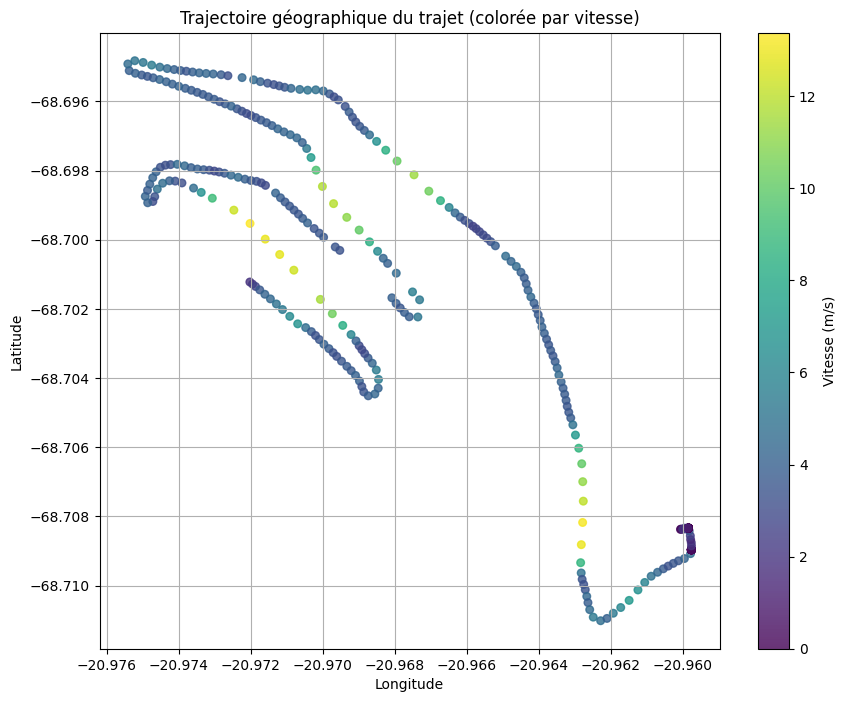

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

segment = load_segment_list[5].copy()
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'], errors='coerce')
segment = segment.dropna(subset=['Time_utc'])

plt.figure(figsize=(10, 8))

# Scatter plot avec couleur selon vitesse, sans légende automatique
scatter = plt.scatter(
    segment['Latitude_dd'], 
    segment['Longitude_dd'], 
    c=segment['Speed_mps'], 
    cmap='viridis',
    s=30,
    alpha=0.8
)

plt.title("Trajectoire géographique du trajet (colorée par vitesse)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Ajout colorbar (échelle de couleur)
cbar = plt.colorbar(scatter)
cbar.set_label('Vitesse (m/s)')

plt.show()


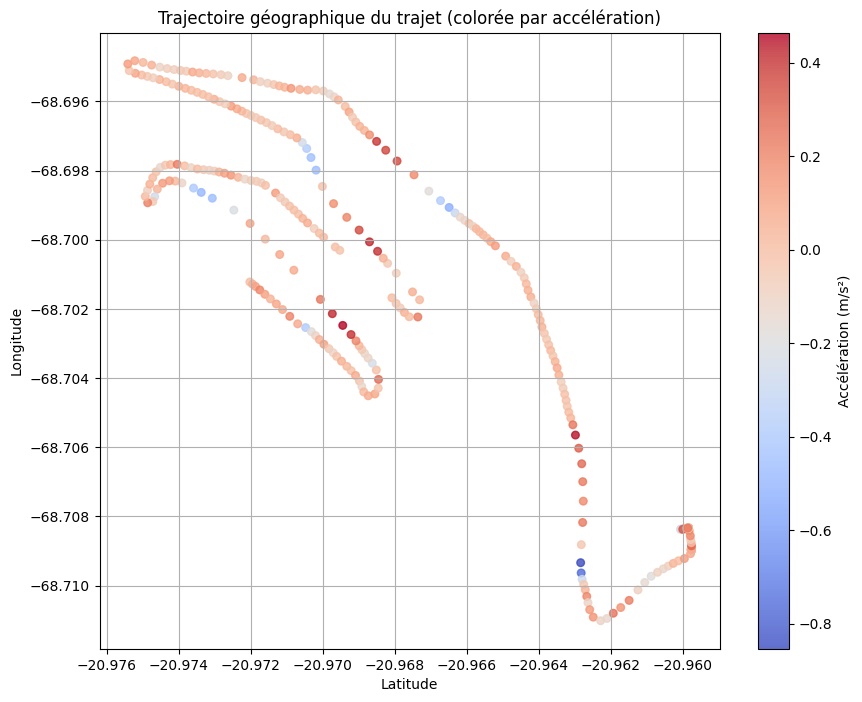

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

segment = load_segment_list[5].copy()
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'], errors='coerce')
segment = segment.dropna(subset=['Time_utc'])

# Calcul de dt_s et accélération
segment = segment.sort_values('Time_utc').reset_index(drop=True)
segment['dt_s'] = segment['Time_utc'].diff().dt.total_seconds()
segment['acceleration_mps2'] = segment['Speed_mps'].diff() / segment['dt_s']
segment['acceleration_mps2'] = segment['acceleration_mps2'].fillna(0)

plt.figure(figsize=(10, 8))

# Scatter plot coloré par accélération
scatter = plt.scatter(
    segment['Latitude_dd'], 
    segment['Longitude_dd'], 
    c=segment['acceleration_mps2'], 
    cmap='coolwarm',   # palette qui met en valeur accélérations positives et négatives
    s=30,
    alpha=0.8
)

plt.title("Trajectoire géographique du trajet (colorée par accélération)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(True)

# Ajout colorbar (échelle de couleur)
cbar = plt.colorbar(scatter)
cbar.set_label('Accélération (m/s²)')

plt.show()


Du coup, on observe :

    - Accélération positives modérés (0 à 0.4 pour la Traj = 5)
    - Décélérations plus fortes : le poids du véhicule et le fait ou non si il est chargé ou non a un impact ou pas sur l'usure des pneus, rencontre ou non des cailloux dans les mines.

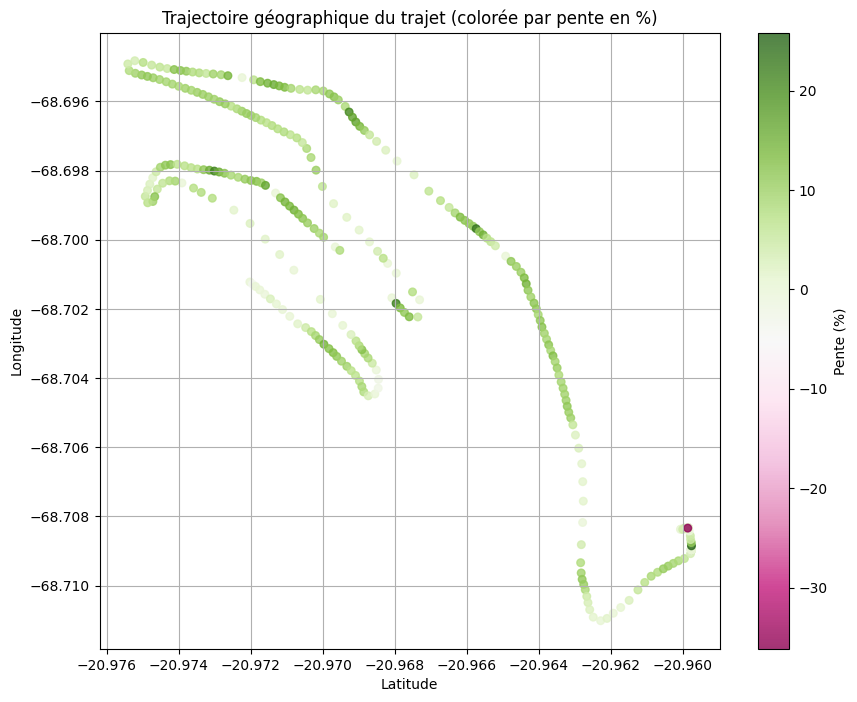

In [43]:
segment = load_segment_list[5].copy()
segment['Time_utc'] = pd.to_datetime(segment['Time_utc'], errors='coerce')
segment = segment.dropna(subset=['Time_utc']).sort_values('Time_utc').reset_index(drop=True)

# Calcul delta altitude
segment['delta_altitude'] = segment['Altitude_m'].diff().fillna(0)

# On suppose que tu as une colonne 'dd_m' qui est la distance entre points en mètres
# Pour éviter la division par zéro, on remplace les distances nulles par NaN
segment['distance_nozero'] = segment['dd_m'].replace(0, np.nan)

# Calcul de la pente en %
segment['pente_pct'] = (segment['delta_altitude'] / segment['distance_nozero']) * 100
segment['pente_pct'] = segment['pente_pct'].fillna(0)

# Plot trajectoire colorée par pente
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    segment['Latitude_dd'],
    segment['Longitude_dd'],
    c=segment['pente_pct'],
    cmap='PiYG',  # Vert <-> rose pour descente/montée
    s=30,
    alpha=0.8
)

plt.title("Trajectoire géographique du trajet (colorée par pente en %)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(True)

cbar = plt.colorbar(scatter)
cbar.set_label('Pente (%)')

plt.show()


On observe prncipalement que le véhicule est en montée et sur du plat sauf la fin ou il est en descente du coup abime les pneuse si il chargé ou non

## 3. Distance Metrics for Trajectories 
Learn and apply suitable distance measures for trajectories. These may include Euclidean distance, Dynamic Time Warping (DTW), or Fréchet distance. Experiment with different metrics to find the most suitable one for clustering vehicle trajectories.
Trajectory Construction ( Based on the preprocessed data, construct trajectories that reflect the vehicle's movement over time. Define how you will represent a trajectory (e.g., as a series of time-stamped GPS coordinates or motion states).